In [1]:
import torch
import matplotlib.pyplot as plt
import pyvista as pv
import json
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import glob 
pv.set_jupyter_backend('static')

OFFSET = 0 


In [2]:
def plot_pcs_recon(ref_pcs,sample_pcs,jnt_pcs,offset=0):
        
    pl = pv.Plotter(shape=(3,10), window_size=[2000, 600],border=False,polygon_smoothing=True)

    for col in range(10):
        points = ref_pcs[col+offset].reshape(-1, 3).detach().cpu().numpy()
        pl.subplot(0, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=2,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )
        points = sample_pcs[col+offset].reshape(-1, 3).detach().cpu().numpy()
        pl.subplot(1, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=2,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )
        points = jnt_pcs[col+offset].reshape(-1, 3).detach().cpu().numpy()
        pl.subplot(2, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=2,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


    pl.background_color = "w"
    pl.link_views()
    pl.camera_position = "xy"
    pos = pl.camera.position
    pl.camera.position = (pos[0],pos[1]+3,pos[2])
    pl.camera.position = (6,0,0)
    pl.camera.azimuth = 45
    pl.camera.elevation = 30
    # create a top down light
    light = pv.Light(position=(0, 0, 0), positional=True,
                    cone_angle=50, exponent=20, intensity=.2)
    pl.add_light(light)
    pl.camera.zoom(1.3)
    pl.show()

In [3]:
def table_to_latex_row(dg):
    table_row = ""
    for record in dg[["MMD-CD","MMD-EMD"]].to_records(index=False):
        for idx in range(0,len(record),2):
            table_row += f'${record[idx]:,.2f} \pm {record[idx+1]:,.2f}$ & '

    table_row = table_row[:-2] + '\\\\'
    return table_row


# Reconstruction Results

In [4]:
fn = glob.glob("./results/**/**.json")
results = []
for filename in fn:
    with open(filename,"r") as f:
        results.extend(json.load(f))

df = pd.DataFrame(results)
df["cate"] = pd.Categorical(df['cate'],categories=['airplane','chair','car'],ordered=True)
df.sort_values("cate")

MMD-CD  MMD-EMD  fscore      model      cate  normalized
0      0.00     0.00    1.00    Encoder  airplane       False
120    0.00     0.01    1.00        VAE  airplane       False
121    0.00     0.01    1.00        VAE  airplane       False
122    0.00     0.00    0.99        VAE  airplane       False
123    0.00     0.01    0.99        VAE  airplane       False
..      ...      ...     ...        ...       ...         ...
145    0.00     0.01    0.88        VAE       car       False
146    0.00     0.01    0.88        VAE       car       False
147    0.00     0.01    0.89        VAE       car       False
149    0.00     0.01    0.89        VAE       car       False
89     0.00     0.01    0.95  PointFlow       car       False

[180 rows x 6 columns]

In [5]:
df["MMD-CD"] = df["MMD-CD"] * 1e4
df["MMD-EMD"] = df["MMD-EMD"] * 1e3
df["normalized"] = df["normalized"].astype(str)

In [6]:
dg = df.groupby(["normalized","model","cate"]).agg(["mean","std"])
models = dg.index.get_level_values('model').unique().tolist()
dg

MMD-CD      MMD-EMD      fscore     
                                mean  std    mean  std   mean  std
normalized model     cate                                         
False      Encoder   airplane   1.32 0.00    4.86 0.05   1.00 0.00
                     chair     14.81 0.06   18.36 0.10   0.83 0.00
                     car        7.34 0.02   10.63 0.11   0.94 0.00
           PointFlow airplane   1.30 0.00    5.37 0.08   1.00 0.00
                     chair     10.43 0.02   17.59 0.13   0.89 0.00
                     car        6.94 0.01   13.02 0.17   0.95 0.00
           VAE       airplane   1.66 0.01    5.03 0.07   0.99 0.00
                     chair     15.99 0.08   18.47 0.12   0.82 0.00
                     car       10.26 0.08   11.76 0.25   0.88 0.00
True       Encoder   airplane   8.82 0.03   31.60 0.42   0.92 0.00
                     chair     60.60 0.18   73.00 0.53   0.43 0.00
                     car      133.07 1.35   66.00 0.46   0.45 0.00
           PointFlow airplane   8.67 0.03   35.13 0.71   0.92 0.00
                     chair     42.87 0.09   70.28 0.49   0.48 0.00
                     car       38.87 0.43   67.12 1.05   0.45 0.00
           VAE       airplane  11.07 0.09   32.77 0.36   0.89 0.00
                     chair     65.35 0.34   73.62 0.38   0.42 0.00
                     car      162.34 7.04   75.25 1.23   0.36 0.00

In [7]:
print("Unnormalized results")
for model in models: 
    table_row = f"{model} &" + table_to_latex_row(dg.loc["False",model])
    print(table_row)

print("Normalized results")
for model in models: 
    table_row = f"{model} & " + table_to_latex_row(dg.loc["True",model])
    print(table_row)

Unnormalized results
Encoder &$1.32 \pm 0.00$ & $4.86 \pm 0.05$ & $14.81 \pm 0.06$ & $18.36 \pm 0.10$ & $7.34 \pm 0.02$ & $10.63 \pm 0.11$ \\
PointFlow &$1.30 \pm 0.00$ & $5.37 \pm 0.08$ & $10.43 \pm 0.02$ & $17.59 \pm 0.13$ & $6.94 \pm 0.01$ & $13.02 \pm 0.17$ \\
VAE &$1.66 \pm 0.01$ & $5.03 \pm 0.07$ & $15.99 \pm 0.08$ & $18.47 \pm 0.12$ & $10.26 \pm 0.08$ & $11.76 \pm 0.25$ \\
Normalized results
Encoder & $8.82 \pm 0.03$ & $31.60 \pm 0.42$ & $60.60 \pm 0.18$ & $73.00 \pm 0.53$ & $133.07 \pm 1.35$ & $66.00 \pm 0.46$ \\
PointFlow & $8.67 \pm 0.03$ & $35.13 \pm 0.71$ & $42.87 \pm 0.09$ & $70.28 \pm 0.49$ & $38.87 \pm 0.43$ & $67.12 \pm 1.05$ \\
VAE & $11.07 \pm 0.09$ & $32.77 \pm 0.36$ & $65.35 \pm 0.34$ & $73.62 \pm 0.38$ & $162.34 \pm 7.04$ & $75.25 \pm 1.23$ \\


# Encoder

### Airplane


################################################################################
### ENCODER
################################################################################


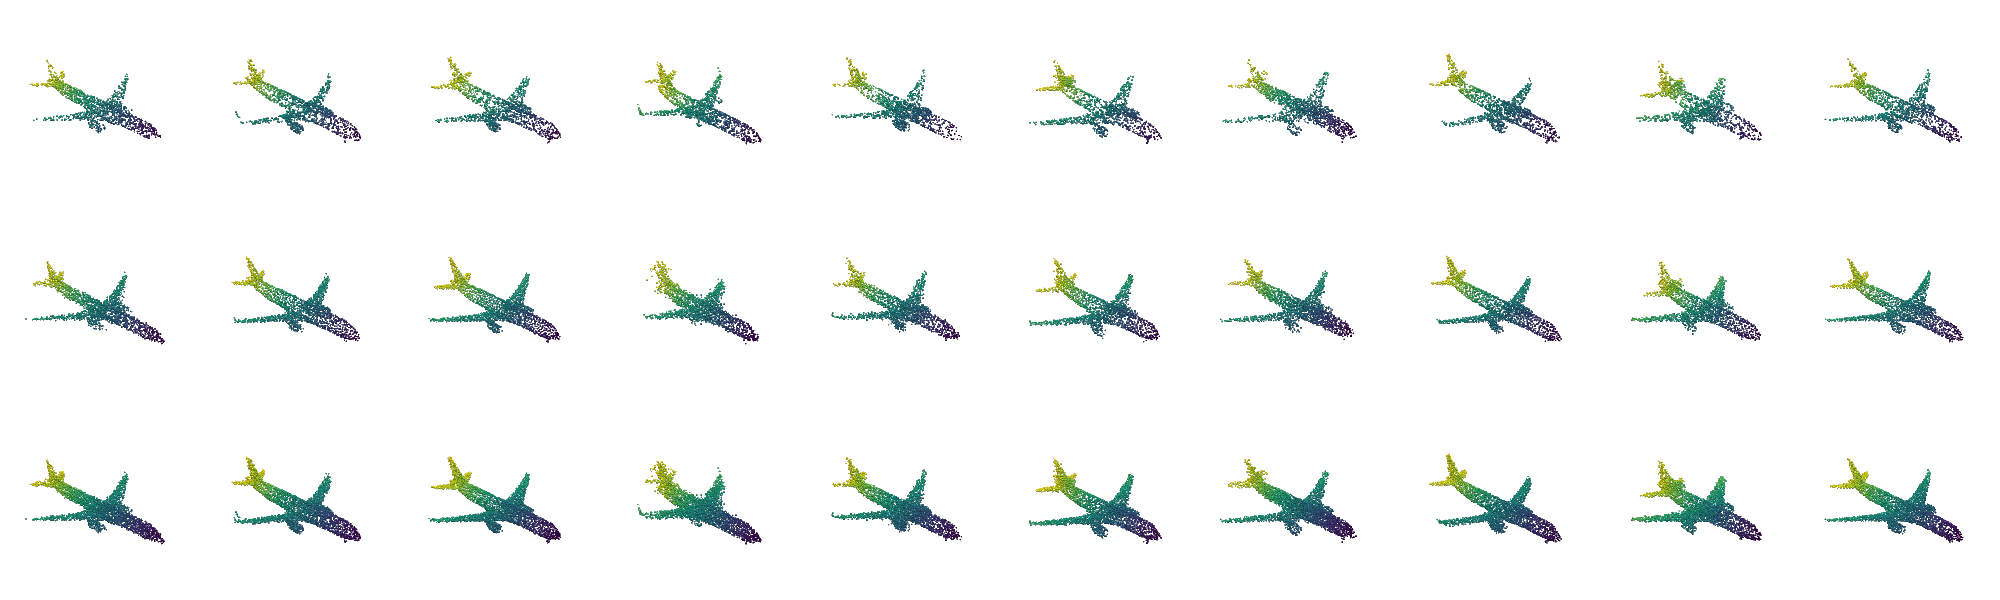

################################################################################
### POINTFLOW
################################################################################


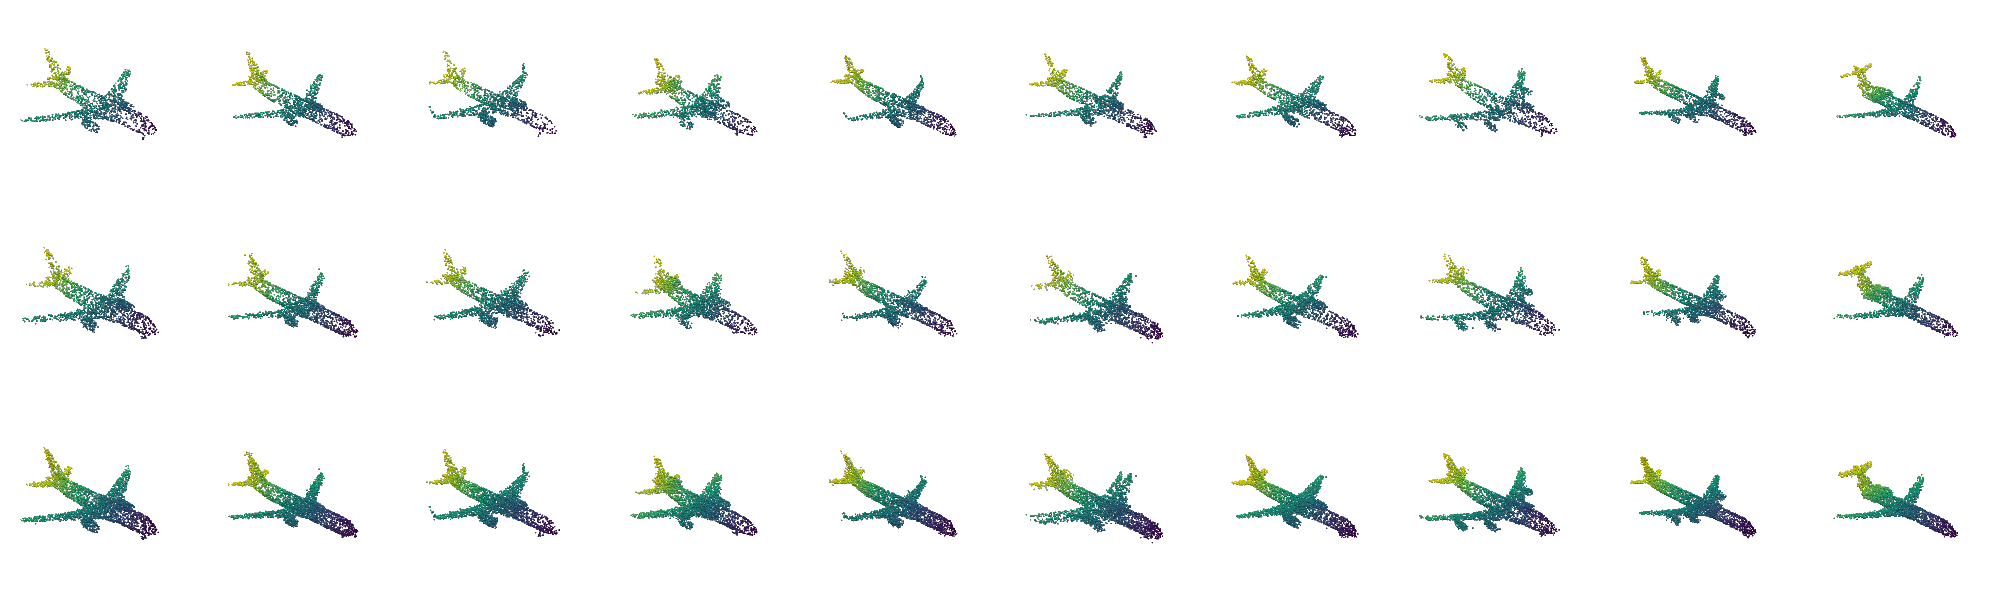

################################################################################
### VAE
################################################################################


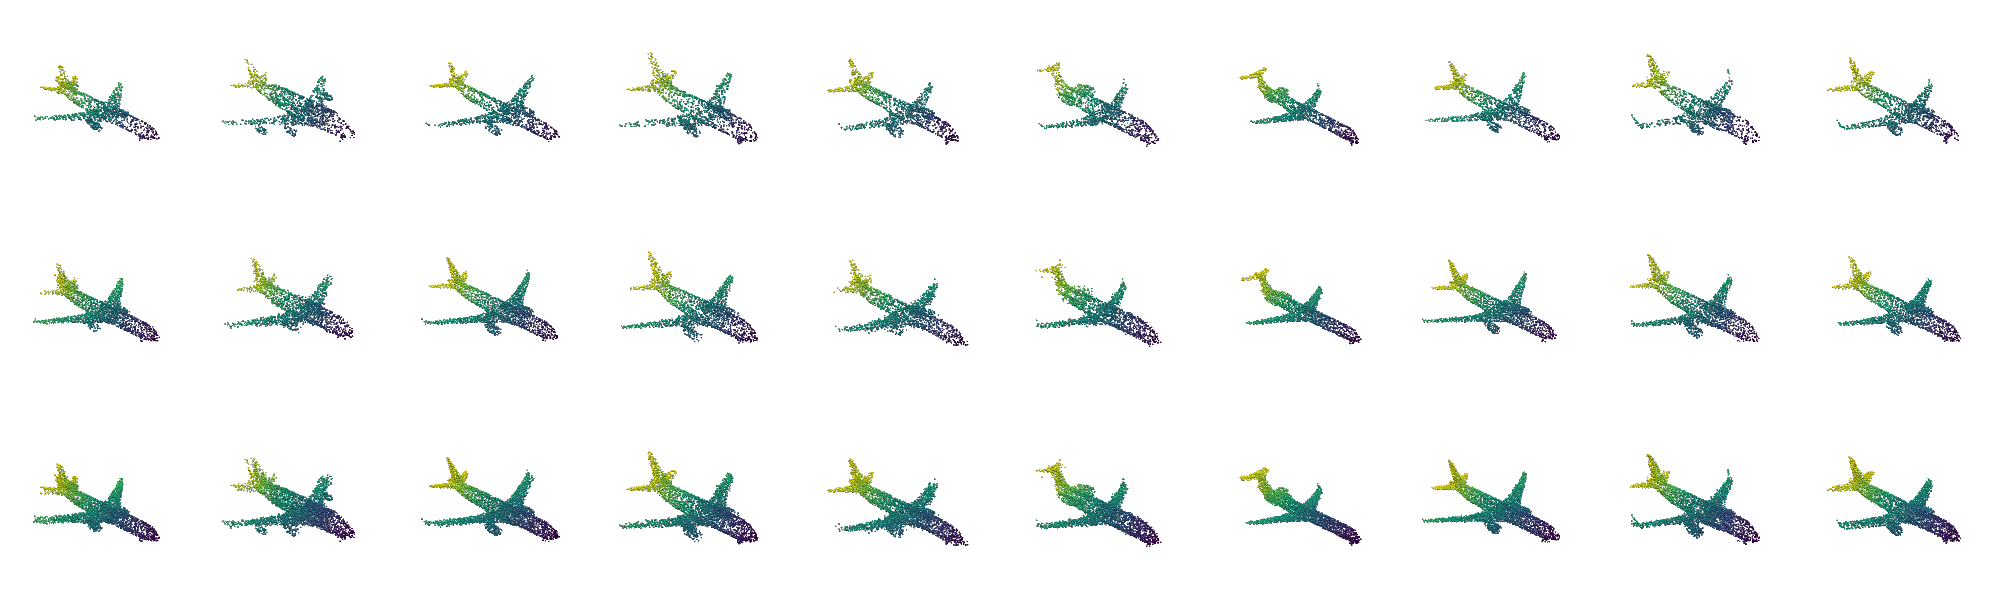

In [8]:
for model in models: 
    print(80*"#")
    print(f"### {model.upper()}")
    print(80*"#")
    sample_pcs = torch.load(f'./results/{model}/samples_airplane_normalized.pt')
    ref_pcs = torch.load(f'./results/{model}/ref_airplane_normalized.pt')
    jnt_pcs = torch.cat([sample_pcs,ref_pcs],axis=1)
    plot_pcs_recon(ref_pcs,sample_pcs,jnt_pcs,offset=0)


### Car

################################################################################
### ENCODER
################################################################################


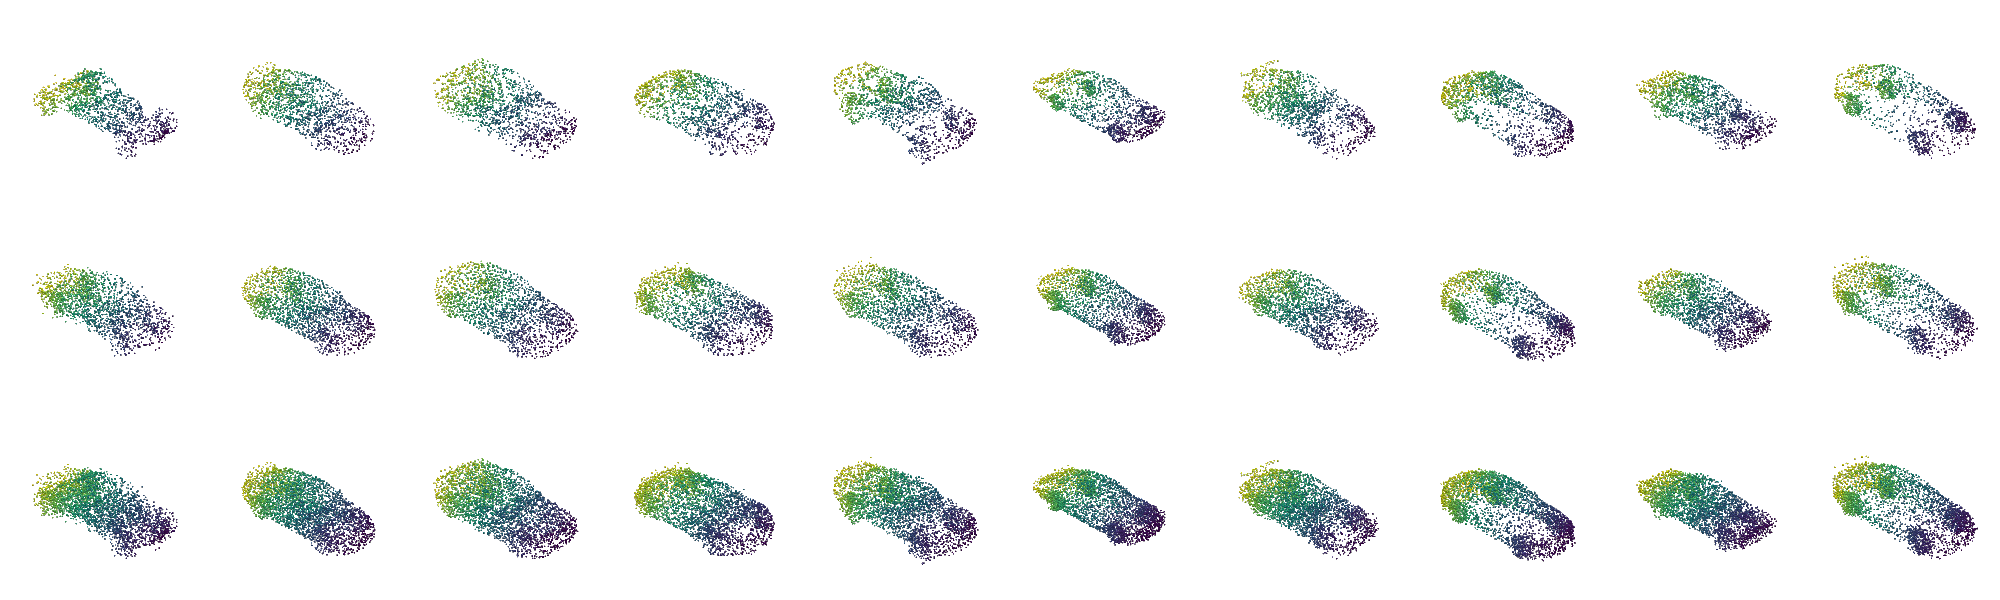

################################################################################
### POINTFLOW
################################################################################


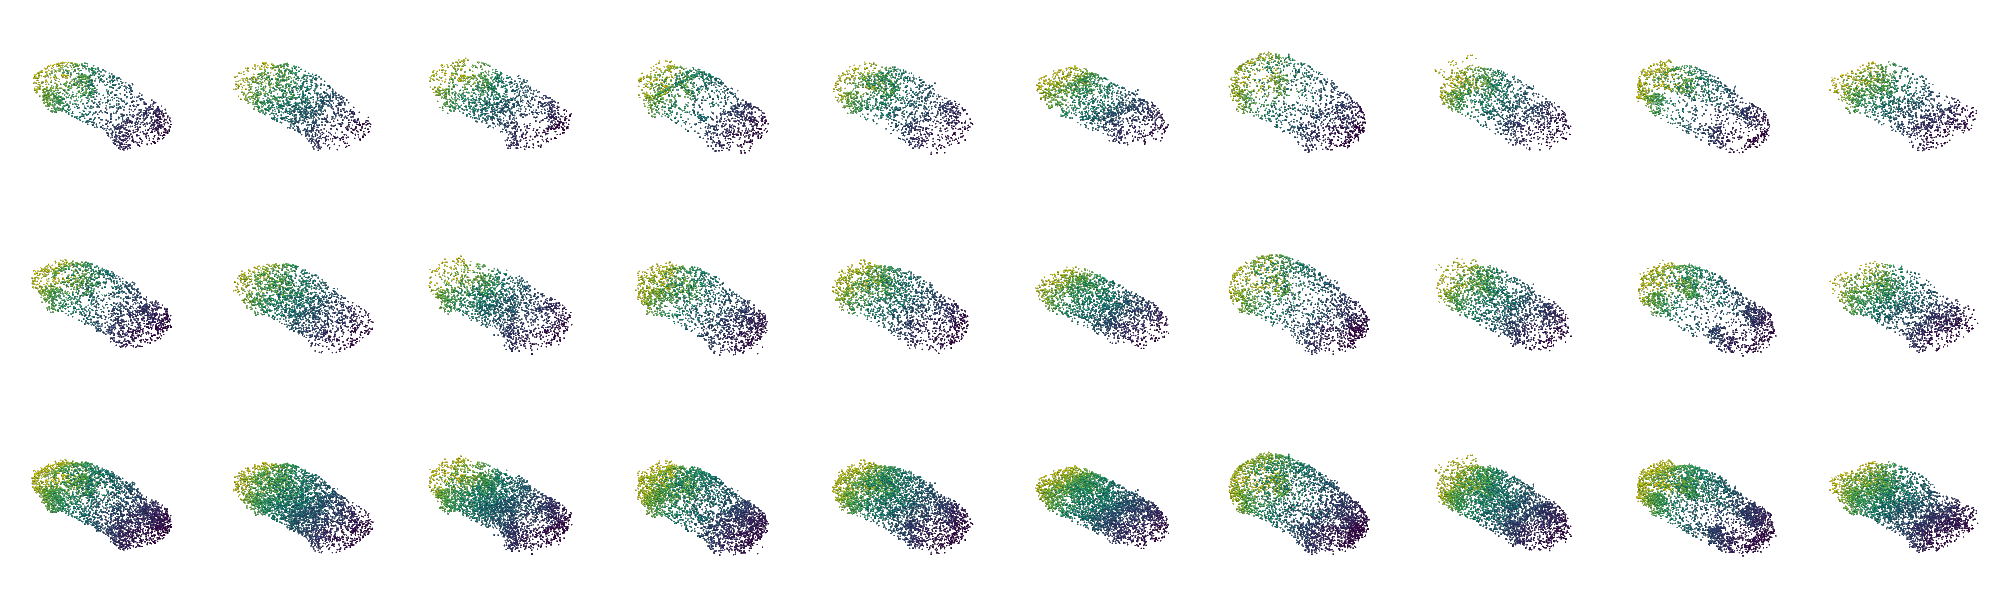

################################################################################
### VAE
################################################################################


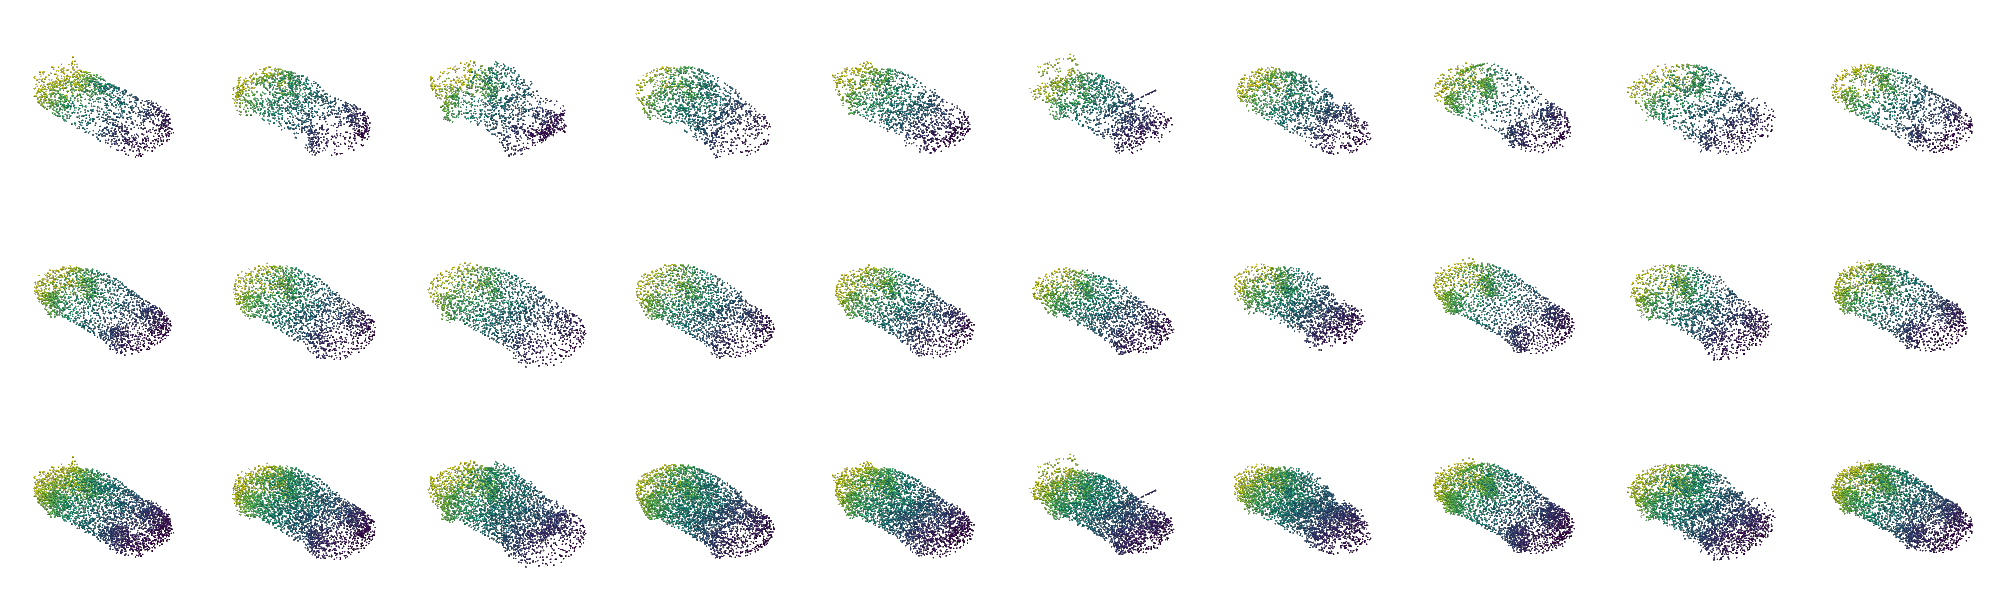

In [9]:
for model in models:
    print(80*"#")
    print(f"### {model.upper()}")
    print(80*"#")
    sample_pcs = torch.load(f'./results/{model}/samples_car_normalized.pt')
    ref_pcs = torch.load(f'./results/{model}/ref_car_normalized.pt')
    jnt_pcs = torch.cat([sample_pcs,ref_pcs],axis=1)
    plot_pcs_recon(ref_pcs,sample_pcs,jnt_pcs,offset=0)

### Chair

################################################################################
### ENCODER
################################################################################


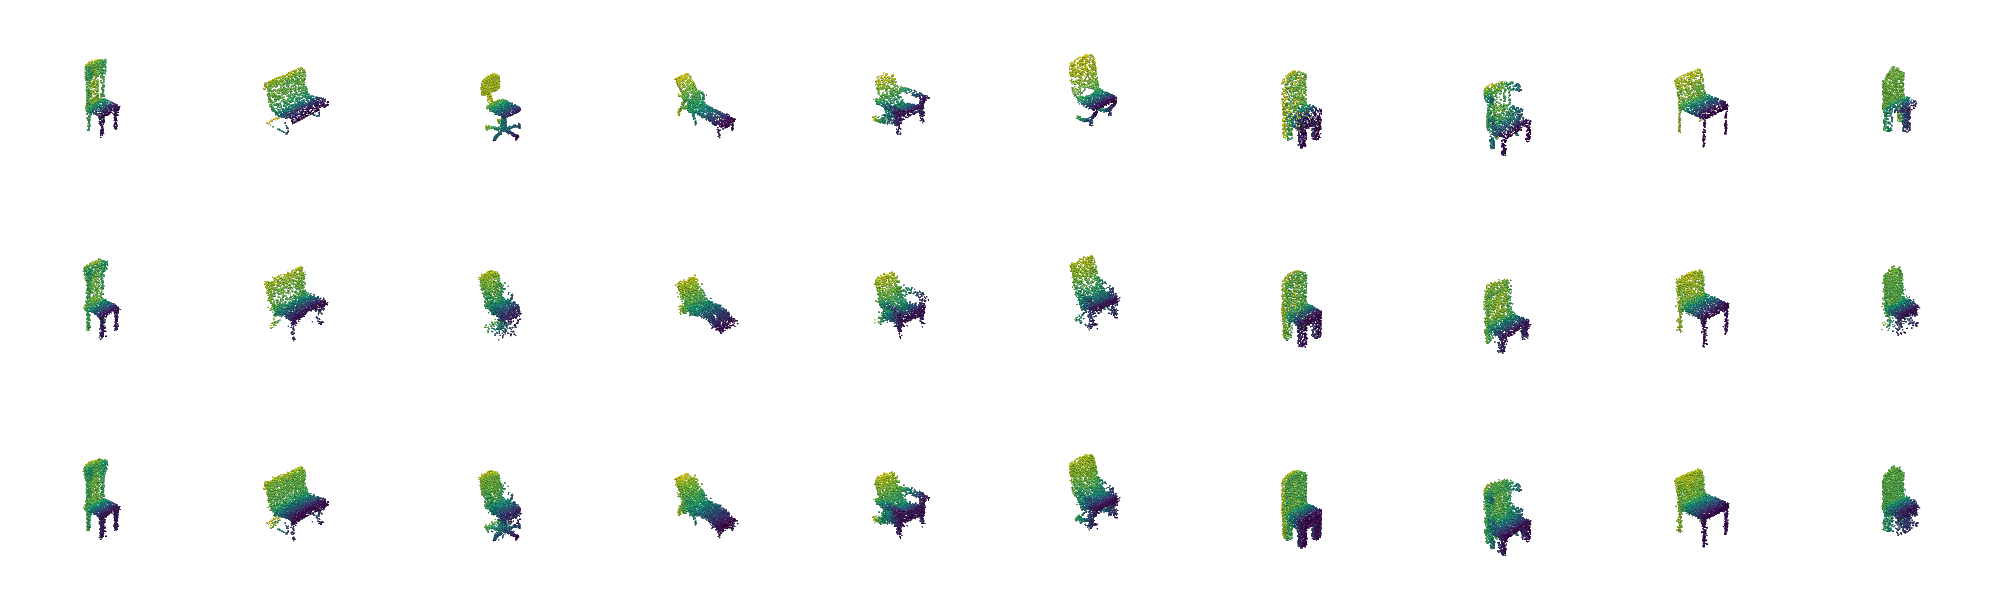

################################################################################
### POINTFLOW
################################################################################


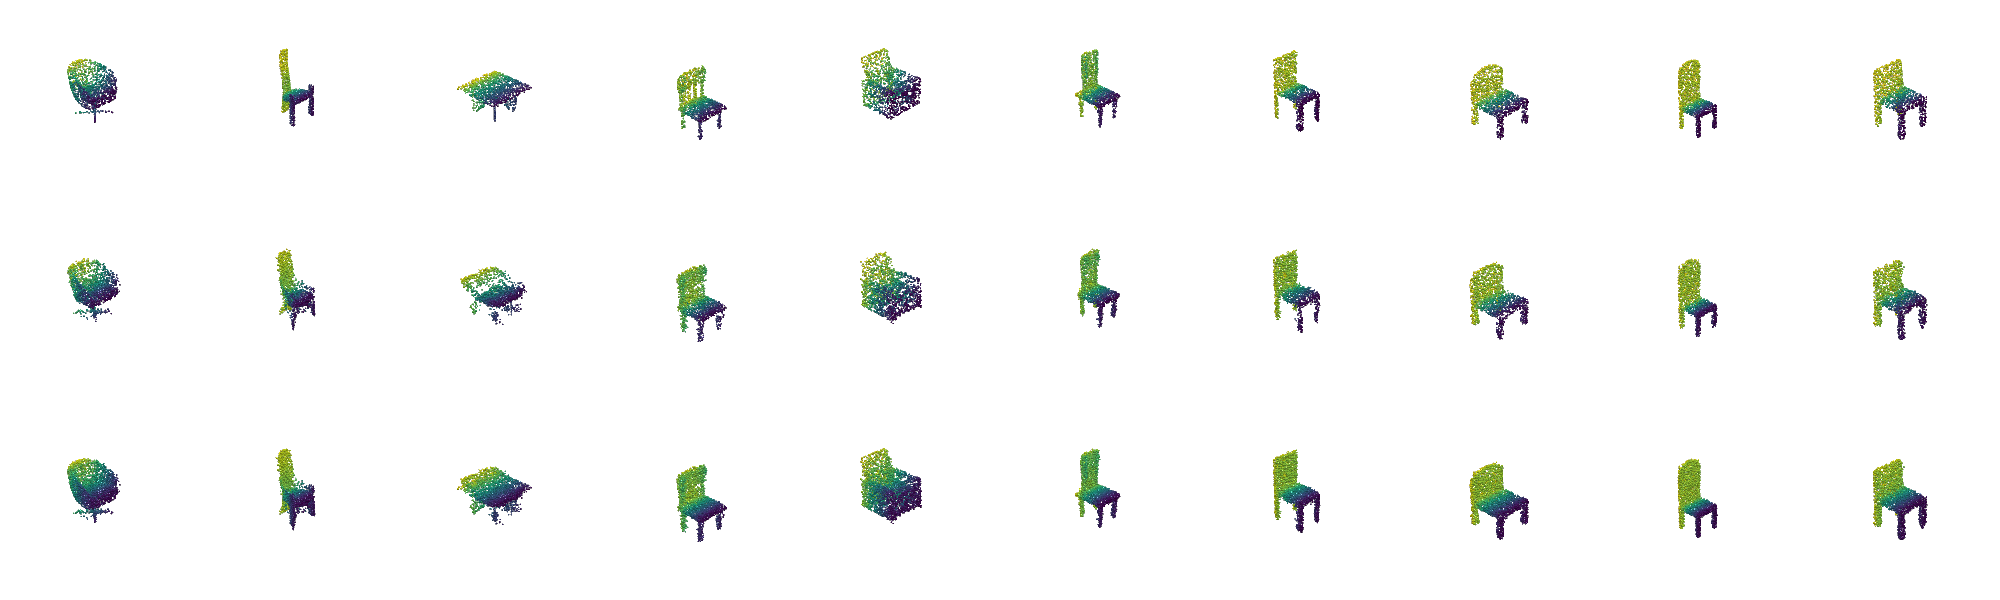

################################################################################
### VAE
################################################################################


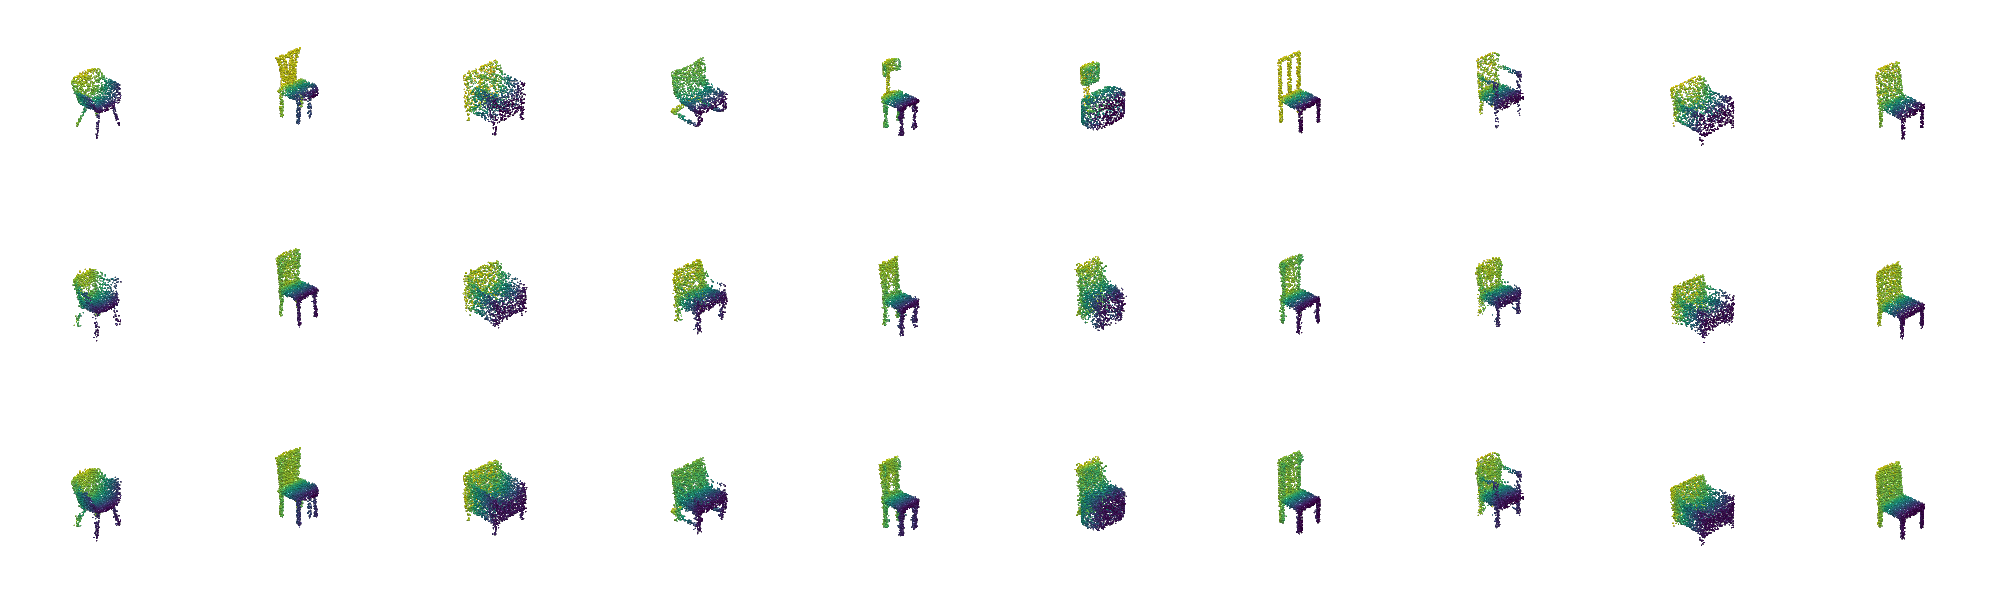

In [10]:
for model in models:
    print(80*"#")
    print(f"### {model.upper()}")
    print(80*"#")
    
    sample_pcs = torch.load(f'./results/{model}/samples_chair.pt')
    ref_pcs = torch.load(f'./results/{model}/ref_chair.pt')
    jnt_pcs = torch.cat([sample_pcs,ref_pcs],axis=1)
    plot_pcs_recon(ref_pcs,sample_pcs,jnt_pcs,offset=0)
